# Exploration11 - 어제 오늘 내 주식, 과연 내일은? 

ARIMA 모델을 이용하여 시계열 데이터를 예측해보자.

---

### 루브릭 평가 기준

1. 시계열의 안정성 확인 - 플로팅과 adfuller 메소드가 모두 적절히 사용되었나
2. ARIMA 모델 모수 선택 근거 제시 - p, q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확하게 제시되었나
3. 예측 모델의 오차율 - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측되었나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 전처리
  - 시계열 안정성 분석
    

2) ARIMA
  - 학습 데이터 분리
  - 적정 모수 찾기
  - 모델 훈련 및 예측


3) 다른 주식 종목 예측
  - IBM
  - SHAK
  - RIVN
    
4) 회고

## 0. 필요 모듈 import

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 데이터의 stationary 확인을 위한 함수 모듈
from statsmodels.tsa.stattools import adfuller
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
# 적정 ARIMA 모수를 찾기 위한 acf, pacf 그래프 모듈
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 학습 시킬 ARIMA 모델
from statsmodels.tsa.arima.model import ARIMA
# 결과 분석을 위한 함수 모듈
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## 1. 데이터 로드 및 전처리

### - 데이터 준비

이번 프로젝트에 사용할 종목은 [삼성전자](https://finance.yahoo.com/quote/005930.KS?p=005930.KS&.tsrc=fin-srch)로, Yahoo Finance에서 구할 수 있다.

In [17]:
dataset_filepath = './data/005930.KS.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


데이터는 각 날짜마다 Open, High, Low, Close, Adj Close, Volume의 값을 가지고 있다.  
그 중 이번 프로젝트에서는 종가인 Close 데이터를 사용하겠다.

In [18]:
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

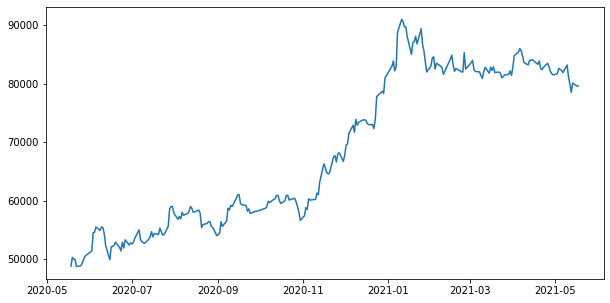

In [19]:
rcParams["figure.figsize"] = [10, 5]
plt.plot(ts)

### - 데이터 전처리


결측치가 있다면 time을 기준으로 이를 보간한 후 결측치 유무를 확인해준다.

In [20]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()] # 결측치가 있는 부분을 Series로 출력

Series([], Name: Close, dtype: float64)

데이터가 50,000 ~ 90,000 사이의 큰 값을 가지므로 이를 로그 변환하여 사용한다.

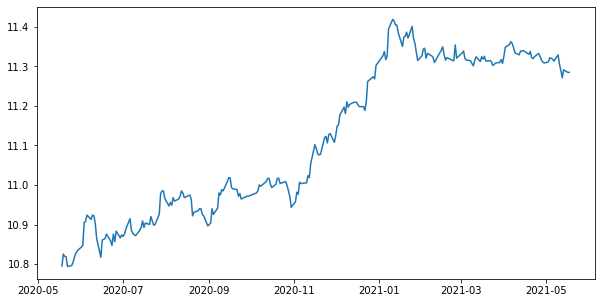

In [21]:
# 로그 변환
ts_log = np.log(ts)

plt.plot(ts_log)

### - 시계열 안정성 분석

In [22]:
# 시계열 안정성 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

슝=3


 #### * Augmented Dickey-Fuller Test(ADF Test)
 
1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다

In [23]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

슝=3


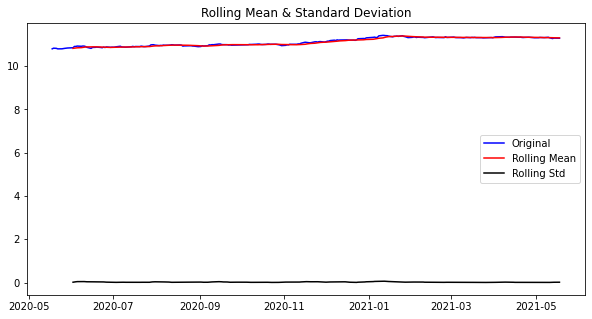

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [43]:
# 시계열 안정성 분석
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

p-value가 0.05 보다 크므로 이 시계열이 안정적이라고 말 할 수는 없다.

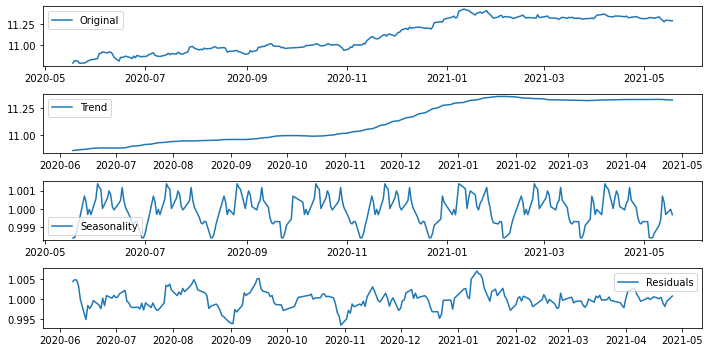

In [44]:
#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


residual에 대한 p-value는 충분히 낮으므로 이 데이터가 안정적이라는 대립가설을 채택할 수 있다.

## 3. ARIMA

### - 학습 데이터 분리

학습과 테스트를 위한 데이터를 9:1로 분리한다.  
이전의 데이터를 바탕으로 예측을 해야하므로 앞부분 90%를 학습 데이터, 뒷부분 10%를 테스트 데이터로 한다.


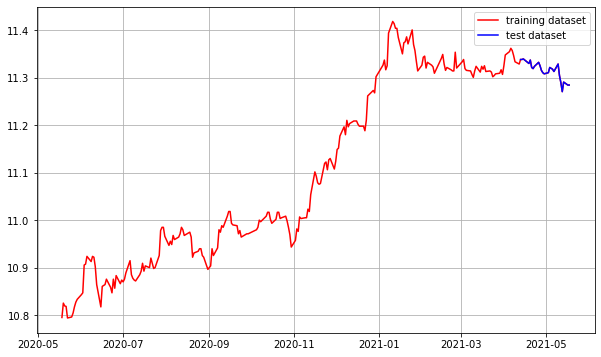

In [26]:
# 학습 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### - 적정 모수 찾기

ARIMA를 효과적으로 활용하기 위한 모수를찾는다.  
ACF 와 PACF 그래프를 통해 결정한다.  
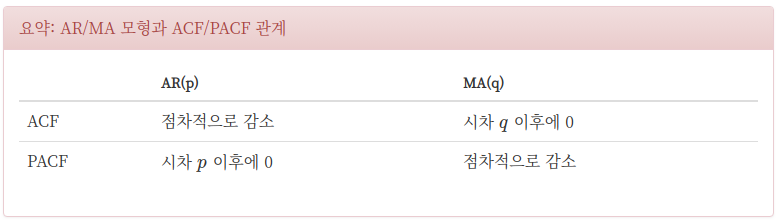

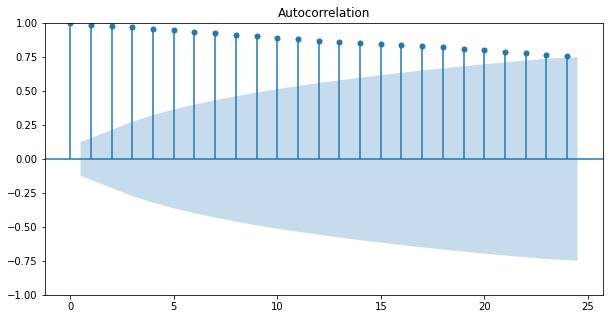

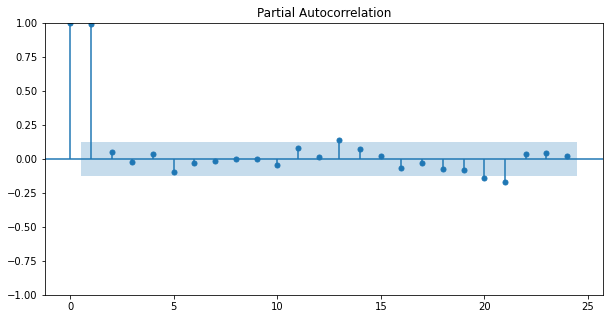

In [39]:
# 적정 ARIMA 모수 찾기

# ACF, PACF 그려보기  >> p, q
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 봤을 때, p가 2 이상인 구간에서 거의 0에 가까우므로 p=1이 적합해 보인다.  
ACF를 봤을 때, 점차 감소하고 있고 q에 대해 적합한 값은 없어보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


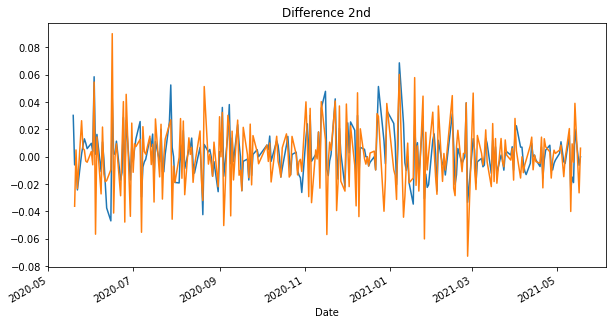

In [28]:
# 차분 안정성 확인 >> d
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


1차 차분만으로도 p-value가 충분히 낮다고 생각하여 d=1이 적당하다고 판단된다.

In [40]:
# ARIMA 모델 훈련과 테스트

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 17 Feb 2022   AIC                          -1162.976
Time:                        06:16:51   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

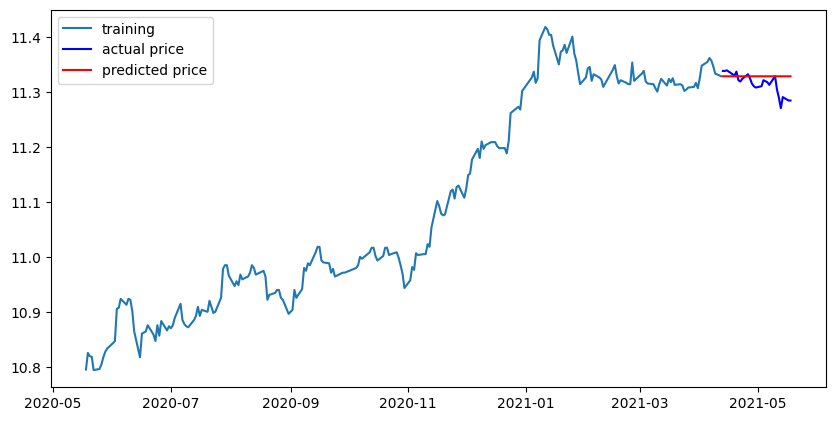

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [42]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


MAPE 기준 1.74%의 오차율을 보이므로 루브릭 기준 만족!!

## 4. 다른 주식 종목 예측

### -  [IBM](https://finance.yahoo.com/quote/IBM?p=IBM&.tsrc=fin-srch)

In [46]:
# 데이터 로드
dataset_filepath = './data/IBM.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')

# 로그 변환
ts_log = np.log(ts)

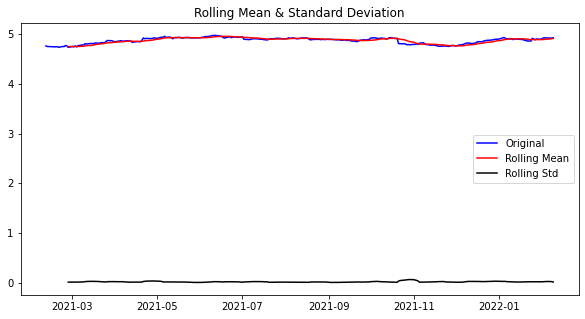

Results of Dickey-Fuller Test:
Test Statistic                  -2.114932
p-value                          0.238553
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.719997
p-value                          0.000077
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


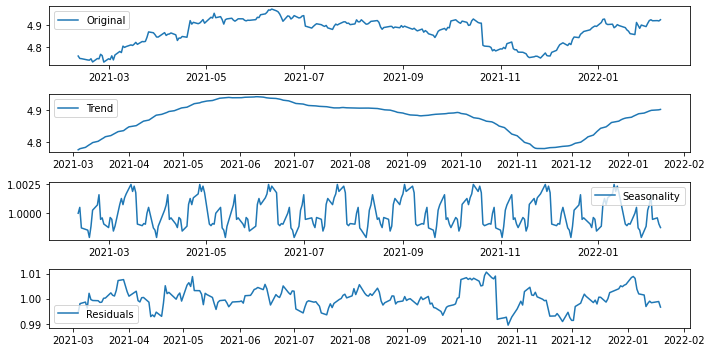

In [47]:
# 시계열 안정성 분석
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

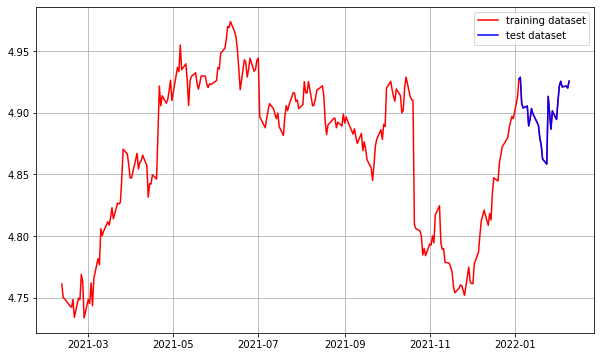

In [48]:
# 학습 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

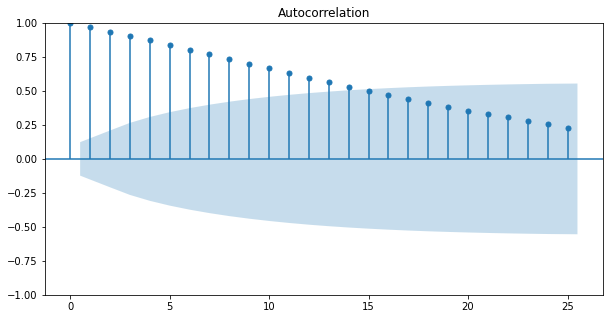

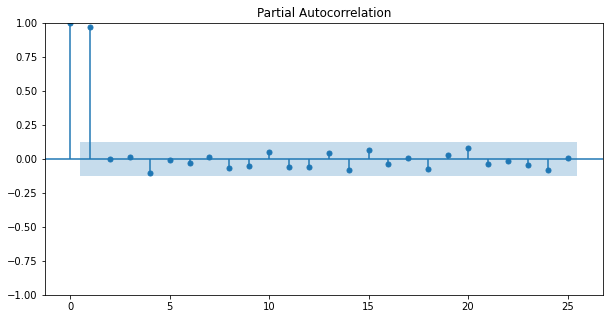

In [51]:
# 적정 ARIMA 모수 찾기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 봤을 때, p가 2 이상인 구간에서 거의 0에 가까우므로 p=1이 적합해 보인다.  
ACF를 봤을 때, 점차 감소하고 있고 q에 대해 적합한 값은 없어보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.647658e+01
p-value                        2.257386e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.054431e+01
p-value                        8.490890e-19
#Lags Used                     6.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


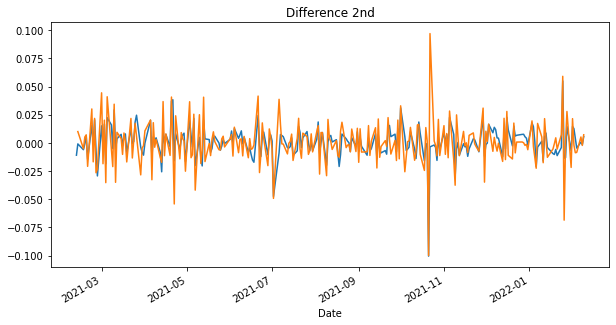

In [52]:
# 차분 안정성 확인 >> d
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 데이터 역시 1차 차분만으로도 p-value가 충분히 낮으므로 d=1이 적당해보인다.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 654.336
Date:                Thu, 17 Feb 2022   AIC                          -1304.673
Time:                        06:33:04   BIC                          -1297.832
Sample:                             0   HQIC                         -1301.912
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0336      0.072     -0.467      0.641      -0.175       0.107
sigma2         0.0002   6.02e-06     29.728      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

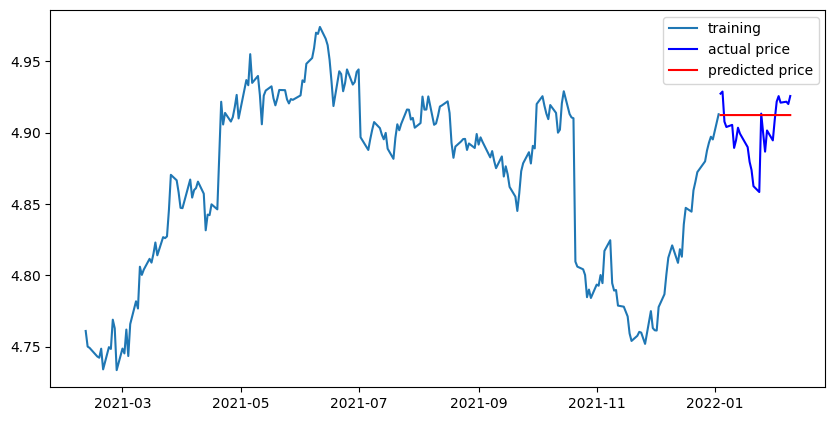

In [53]:
# 모델 설계 및 학습
model = ARIMA(train_data, order=(1, 1, 0))   # 앞에서 구한 모수 사용
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [54]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8.321516082816876
MAE:  2.2980082065918483
RMSE:  2.884703811973922
MAPE: 1.73%


### - [SHAK](https://finance.yahoo.com/quote/SHAK?p=SHAK&.tsrc=fin-srch)

In [55]:
# 데이터 로드
dataset_filepath = './data/SHAK.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')

# 로그 변환
ts_log = np.log(ts)

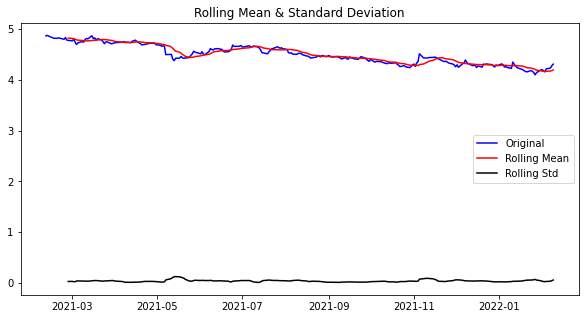

Results of Dickey-Fuller Test:
Test Statistic                  -1.876429
p-value                          0.343230
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.498513
p-value                          0.000002
#Lags Used                       4.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


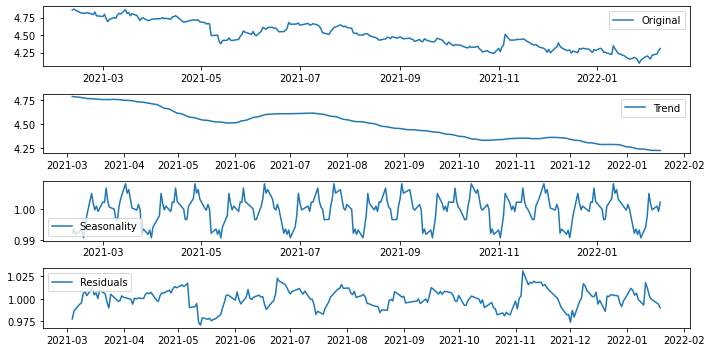

In [56]:
# 시계열 안정성 분석
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

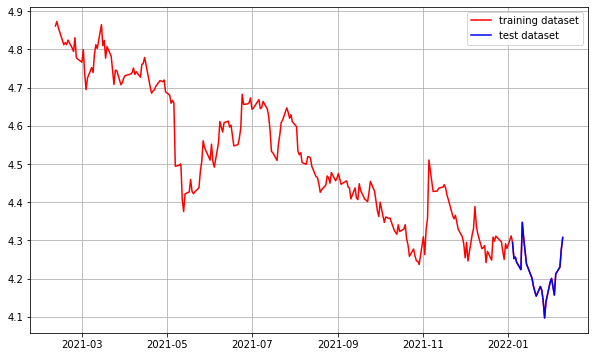

In [57]:
# 학습 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

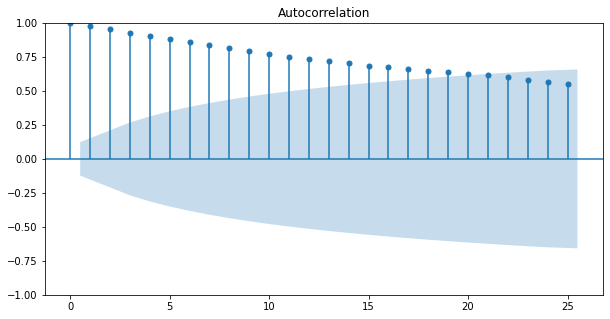

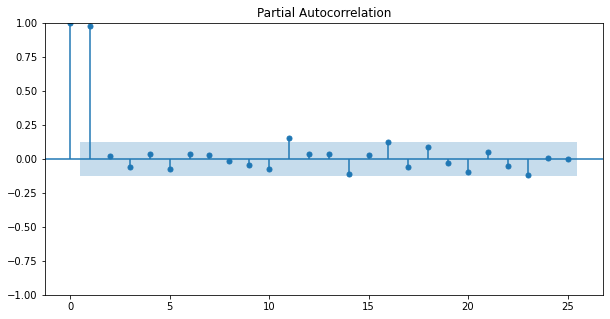

In [58]:
# 적정 ARIMA 모수 찾기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 봤을 때, p가 2 이상인 구간에서 거의 0에 가까우므로 p=1이 적합해 보인다.  
ACF를 봤을 때, 점차 감소하고 있고 q에 대해 적합한 값은 없어보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.726314e+01
p-value                        5.924043e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.684608e+00
p-value                        1.472946e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


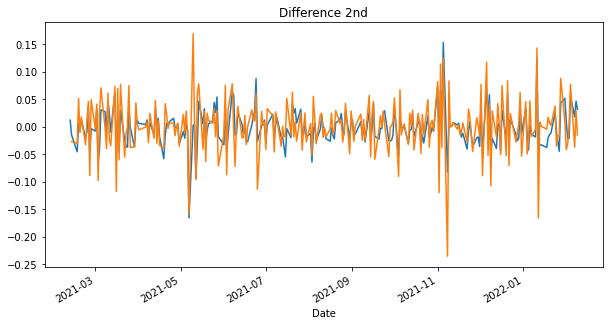

In [59]:
# 차분 안정성 확인 >> d
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 데이터 역시 1차 차분만으로도 p-value가 충분히 낮으므로 d=1이 적당해보인다.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 456.643
Date:                Thu, 17 Feb 2022   AIC                           -909.285
Time:                        06:38:06   BIC                           -902.444
Sample:                             0   HQIC                          -906.524
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1079      0.059     -1.814      0.070      -0.224       0.009
sigma2         0.0010   5.33e-05     19.309      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

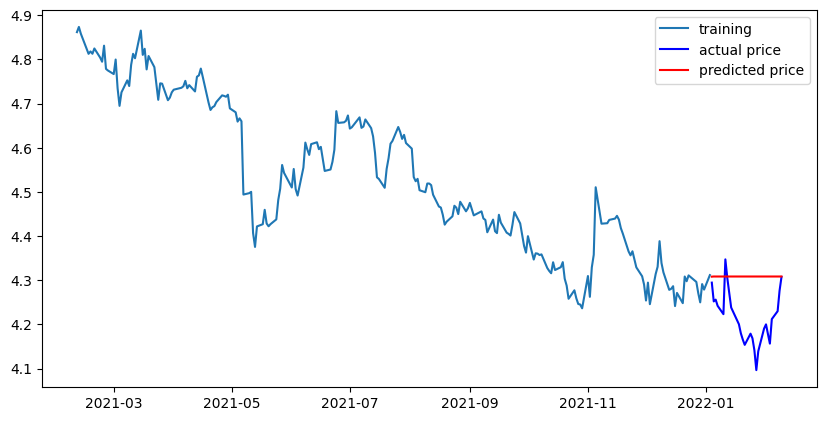

In [60]:
# 모델 설계 및 학습
model = ARIMA(train_data, order=(1, 1, 0))   # 앞에서 구한 모수 사용
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [61]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58.6951095678243
MAE:  6.691551030427964
RMSE:  7.661273364645351
MAPE: 10.22%


### - [RIVN](https://finance.yahoo.com/quote/RIVN?p=RIVN&.tsrc=fin-srch)

In [62]:
# 데이터 로드
dataset_filepath = './data/RIVN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 결측치 처리
ts = ts.interpolate(method='time')

# 로그 변환
ts_log = np.log(ts)

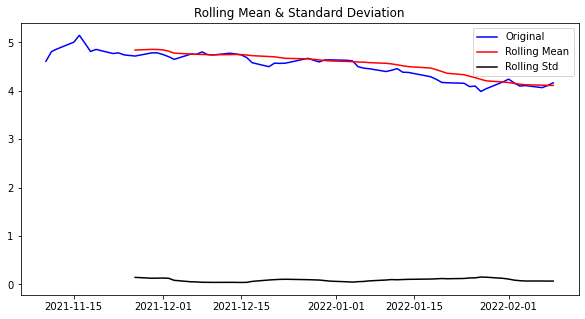

Results of Dickey-Fuller Test:
Test Statistic                 -0.590859
p-value                         0.873034
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -3.697253
p-value                         0.004152
#Lags Used                      2.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


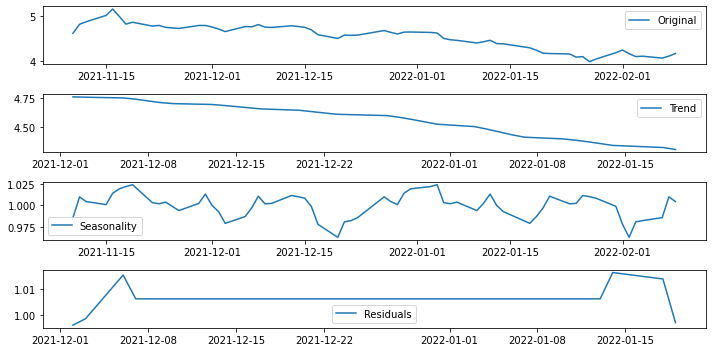

In [63]:
# 시계열 안정성 분석
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

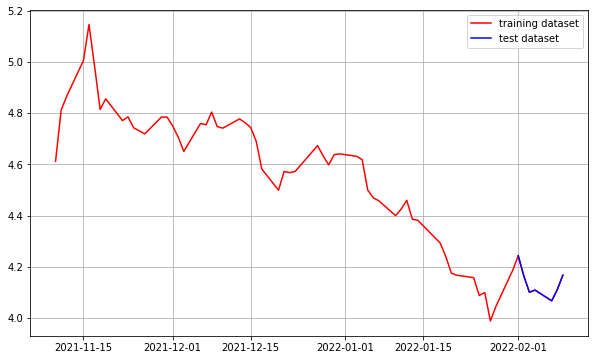

In [64]:
# 학습 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

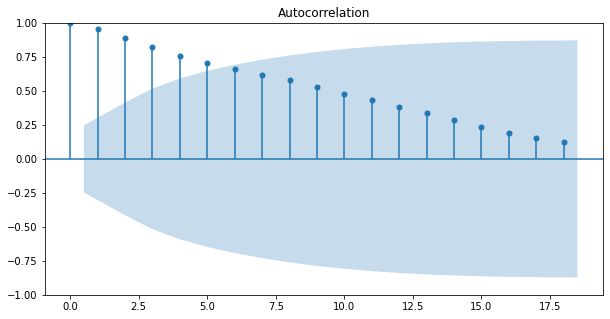

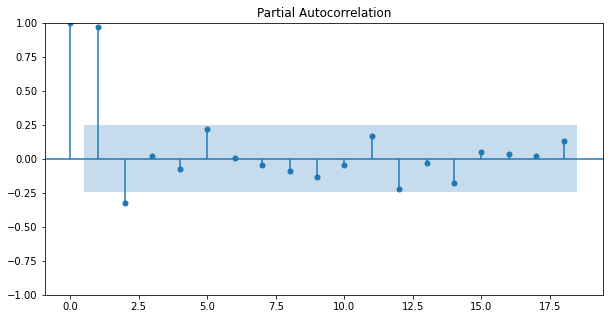

In [65]:
# 적정 ARIMA 모수 찾기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 봤을 때, p가 2 이상인 구간에서 거의 0에 가까우므로 p=1이 적합해 보인다.  
ACF를 봤을 때, 점차 감소하고 있고 q에 대해 적합한 값은 없어보인다.

Results of Dickey-Fuller Test:
Test Statistic                -7.102546e+00
p-value                        4.132169e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.345262e+00
p-value                        1.039636e-10
#Lags Used                     4.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


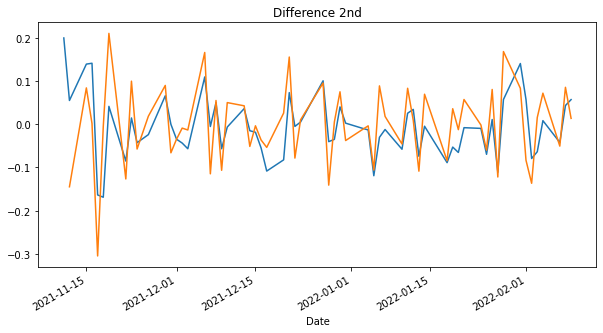

In [66]:
# 차분 안정성 확인 >> d
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 데이터 역시 1차 차분만으로도 p-value가 충분히 낮으므로 d=1이 적당해보인다.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   56
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  65.742
Date:                Thu, 17 Feb 2022   AIC                           -127.485
Time:                        06:38:59   BIC                           -123.470
Sample:                             0   HQIC                          -125.932
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1726      0.115      1.502      0.133      -0.053       0.398
sigma2         0.0054      0.001      5.522      0.000       0.003       0.007
Ljung-Box (L1) (Q):                   0.05   Jarque-

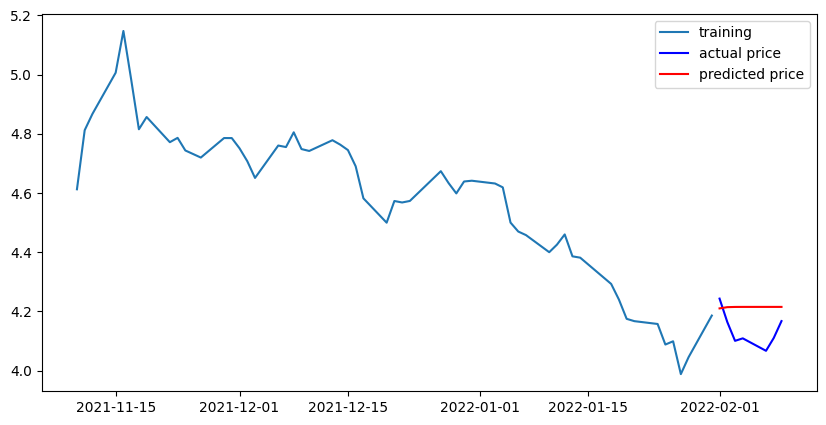

In [67]:
# 모델 설계 및 학습
model = ARIMA(train_data, order=(1, 1, 0))   # 앞에서 구한 모수 사용
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  37.002872696889185
MAE:  5.5681909824858975
RMSE:  6.082998659944714
MAPE: 9.10%


## 회고

#### - 종목 선정

분석할 종목을 고를 때 나의 아픔을 담아(...)보았다.  
실제로 투자할 때 고려할 수 있을 만큼 정확한 모델을 만들 수 있을까?  
이번 프로젝트의 결과로 봐서는 아직도 한참 멀었다는 생각이 든다.  


#### - 이것도 어렵다!!

NLP 노드만 어려운줄 알았더니 이번 노드도 어렵다..  
실습이 어려운 것 보단 내용 이해가 어려웠다.  
개인적으로는 노드의 설명이 부정확하고 부족했다고 생각한다.  
특히 ARIMA 모수를 구하는 부분은 노드 내용만으로는 이해가 불가능했다.  
그리고 AR 모형과 MA 모형에 대한 내용이 있었는데 내가 선정한 종목에 대해서는 모두 AR 모형이었다.  
또한 ARIMA 모델이 이 원리(앞선 시계열 안정성 분석 과정)를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있다고 했는데 왜?! 내가 수동으로 시계열 안정성 분석 과정을 해야하며, 기껏 분석해놓은 residual 데이터는 사용하지 않는 것일까????  
노드 내용 외에 따로 검색을 해보니 ARIMA 모델은 안정적인 시계열 데이터를 사용해야한다고 하는데 노드 내용에선 그저 로그 변환만 한 데이터를 사용한다. 진짜 뭐지...    
나름대로 최대한 이해해보려 노력했지만 실패했다. 


#### - 모두 똑같은 모수?!

서로 다른 종목에 대해서 모두 똑같은 모수를 써야 할 것 같다는 판단을 하게됐다.  
그리고 결과를 보게 되면 그래프의 추세와 상관 없이 예측 시작 시점부터 상수 함수를 그리는듯한 느낌이 든다.  
뭔가 잘못된 것 같지만.. 모르겠다